In [1]:
# Load IPFX libraries
from ipfx.dataset.create import create_ephys_data_set
from ipfx.data_set_features import extract_data_set_features
from ipfx.utilities import drop_failed_sweeps
from ipfx.qc_feature_extractor import sweep_qc_features
from ipfx.stimulus import StimulusOntology
from ipfx.data_set_features import extract_cell_long_square_features

from ipfx.feature_extractor import SpikeFeatureExtractor, SpikeTrainFeatureExtractor
import ipfx.stimulus_protocol_analysis as spa
from ipfx.epochs import get_stim_epoch

#Load Plotting 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# these are basic IPFX objects for working with sweeps and sets of sweeps
from ipfx.sweep import Sweep, SweepSet 

# Load pandas library too
import pandas as pd
from ipfx.dataset.create import create_ephys_data_set
from ipfx.utilities import drop_failed_sweeps

from ipfx.error import FeatureError

#Load json
import json
import allensdk.core.json_utilities as ju

In [2]:
def summarize_ls_ephys_features(lsa_results):
    hero_keep_features = ['adapt', 'avg_rate', 'first_isi', 'isi_cv', 'latency', 'mean_isi', 'median_isi', 
                          'stim_amp']
    rheo_keep_features = ['threshold_v', 'peak_v', 'trough_v', 
     'fast_trough_v', 'adp_v', 'width', 'upstroke_downstroke_ratio', 'peak_t', 'fast_trough_t', 'trough_t']
    
    overall_cell_keep_features = ['v_baseline', 'rheobase_i', 'fi_fit_slope', 
                                  'sag', 'vm_for_sag', 'input_resistance', 'tau']
    
    hero_small_dict = lsa_results['hero_sweep'][hero_keep_features]
    rheobase_sweep_index = lsa_results['rheobase_sweep'].name
    rheobase_sweep = lsa_results['spikes_set'][rheobase_sweep_index].iloc[0]
    
    rheo_spike_small_dict = rheobase_sweep[rheo_keep_features]
    rheo_first_isi = lsa_results['rheobase_sweep']['first_isi']
    rheo_spike_small_dict['rheo_first_isi'] = rheo_first_isi

    spike_comb_dict = {**hero_small_dict, **rheo_spike_small_dict}

    overall_cell_features = {x: lsa_results[x] for x in overall_cell_keep_features if x in lsa_results}
    final_cell_feature_dict = {**spike_comb_dict, **overall_cell_features}
    return(final_cell_feature_dict)

In [3]:
from pathlib import Path
import utils

In [4]:
h2019 = utils.summary_df(Path('./data/processed/recordings/human/h2019/'), suffix='.nwb')
h2018 = utils.summary_df(Path('./data/processed/recordings/human/h2018/'), suffix='.nwb')
m2019 = utils.summary_df(Path('./data/processed/recordings/mouse/m2019/'), suffix='.nwb')
m2018 = utils.summary_df(Path('./data/processed/recordings/mouse/m2018/'), suffix='.nwb')

# add file_id to merge with metadata
h2019['file_id'] = h2019.file_name.apply(lambda x: x.rstrip('.nwb'))
h2018['file_id'] = h2018.file_name.apply(lambda x: x.rstrip('.nwb'))
m2019['file_id'] = m2019.file_name.apply(lambda x: x.rstrip('.nwb'))
m2018['file_id'] = m2018.file_name.apply(lambda x: x.rstrip('.nwb'))

h2019meta = pd.read_csv('./data/processed/meta/h2019_meta.csv', index_col=0)
h2018meta = pd.read_csv('./data/processed/meta/h2018_meta.csv', index_col=0)
m2019meta = pd.read_csv('./data/processed/meta/m2019_meta.csv', index_col=0)
m2018meta = pd.read_csv('./data/processed/meta/m2018_meta.csv', index_col=0)

In [5]:
ontology_path = "./data/stim_ontology_new_Homeira.json"

In [6]:
features_output_path = Path('./data/processed/features')
features_output_path.mkdir(exist_ok=True)

## Process 2019 human longsquares

In [7]:
#cols_to_drop = ['ABF File', 'Data Type', 'Exp. Date', 'Threshold', 'DC', 'ZD', 'Hold']
h2019 = h2019.merge(h2019meta.drop(['file_name', 'path'], axis=1), on='file_id')#.drop(cols_to_drop, axis=1)

In [8]:
h2019[h2019.stimulus_type == 'longsquare'].shape

(48, 50)

/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbe

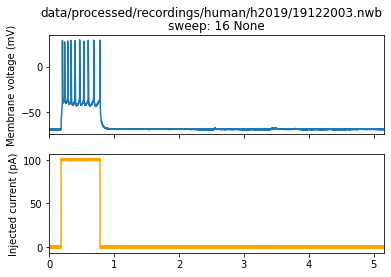

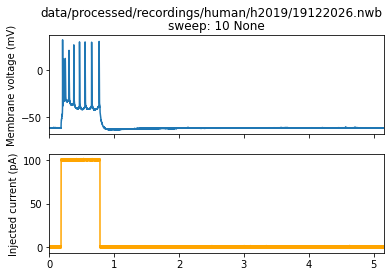

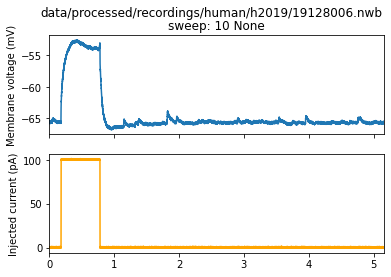

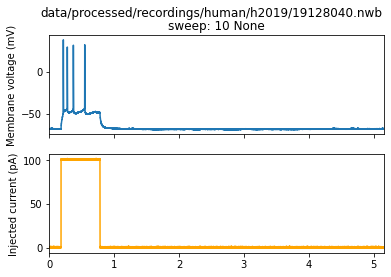

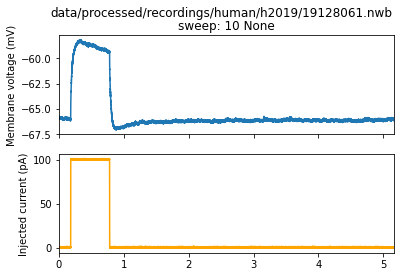

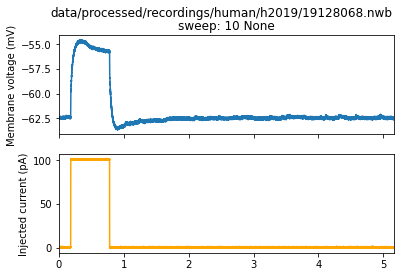

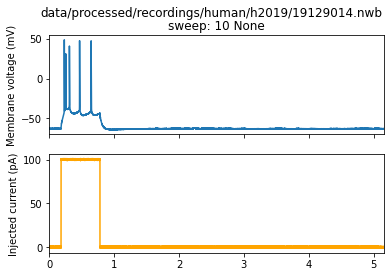

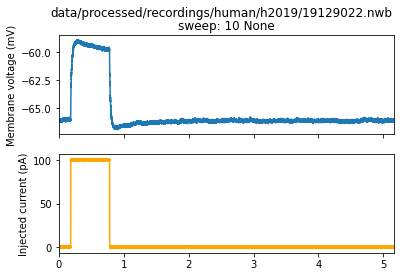

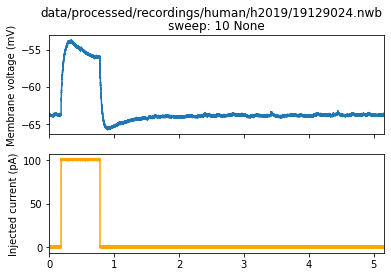

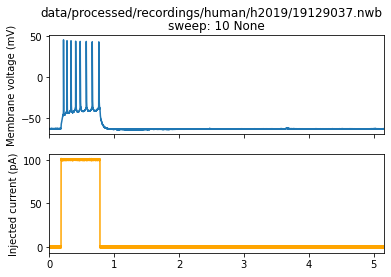

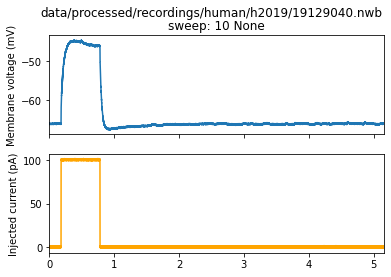

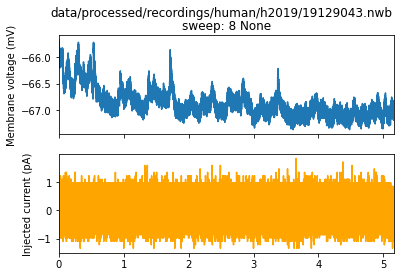

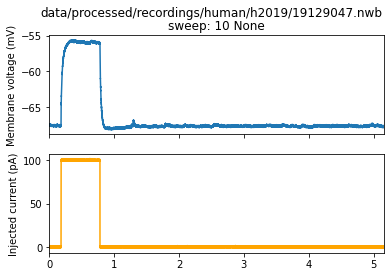

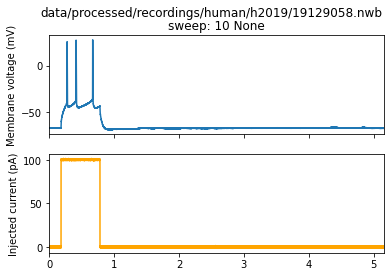

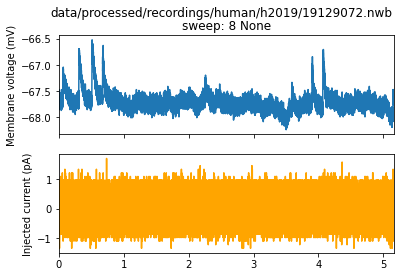

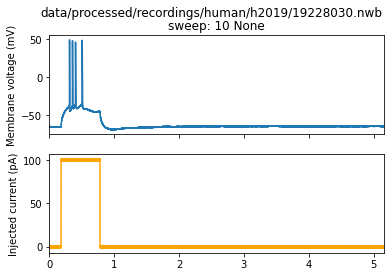

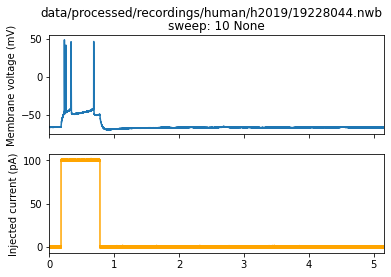

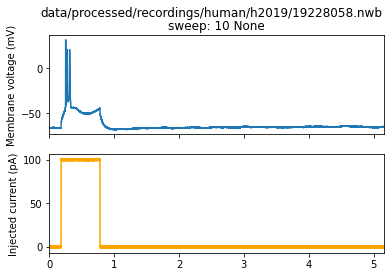

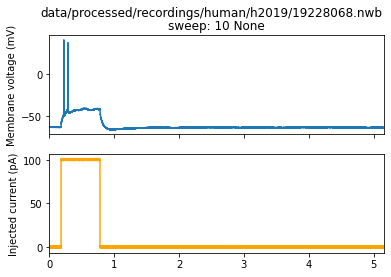

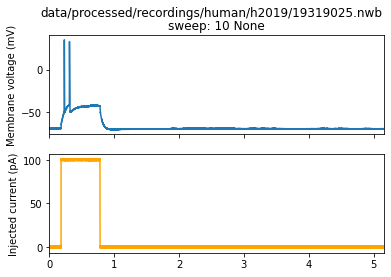

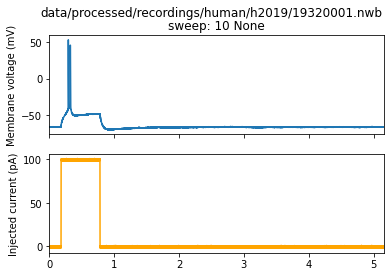

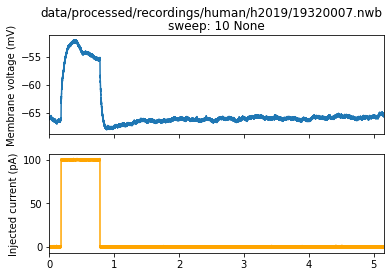

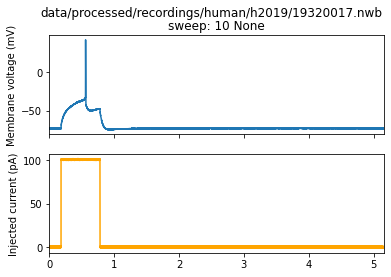

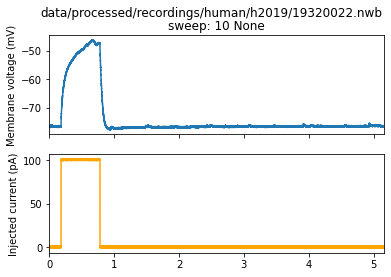

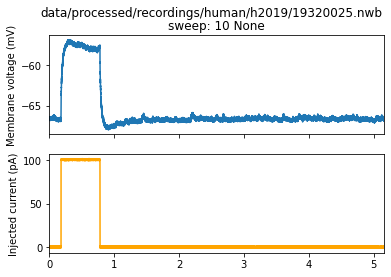

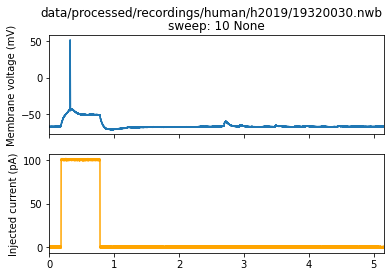

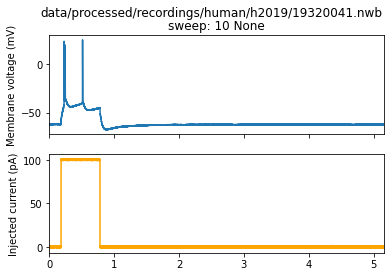

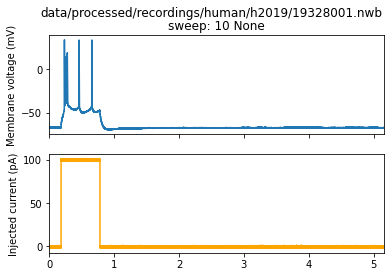

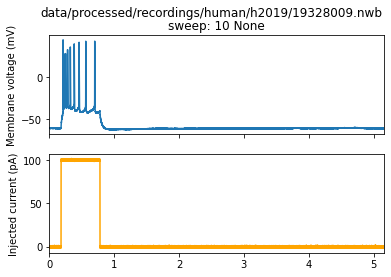

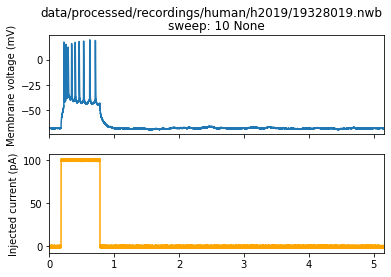

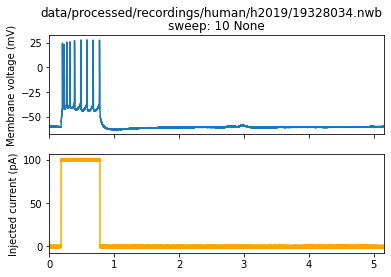

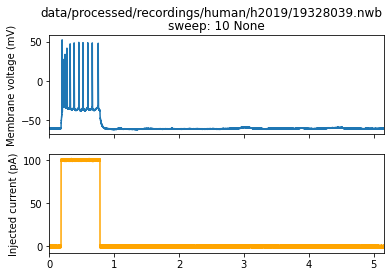

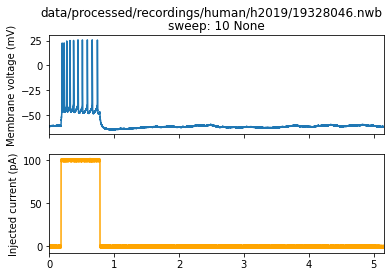

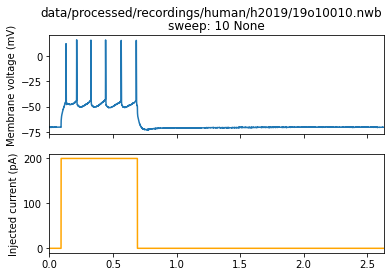

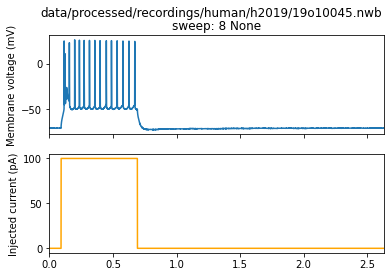

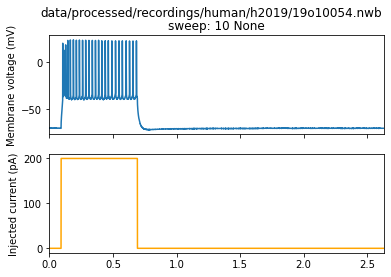

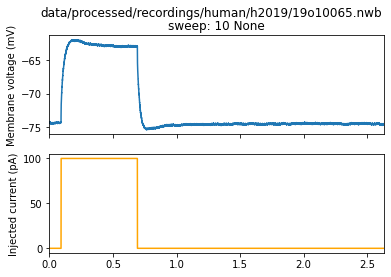

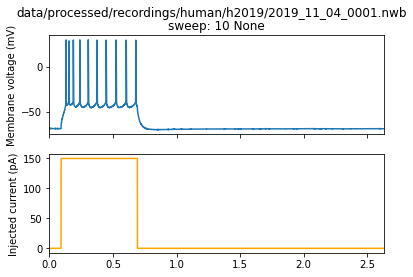

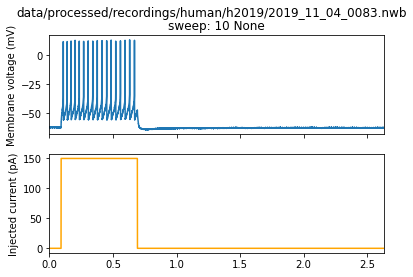

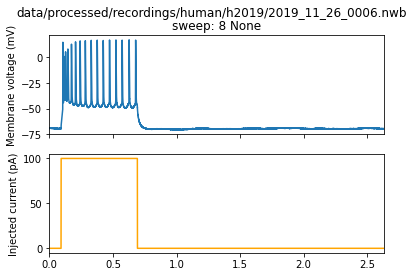

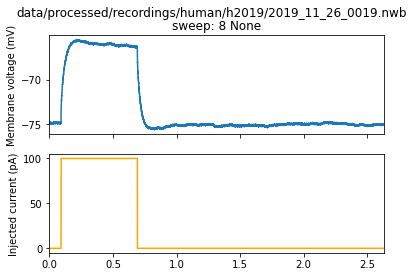

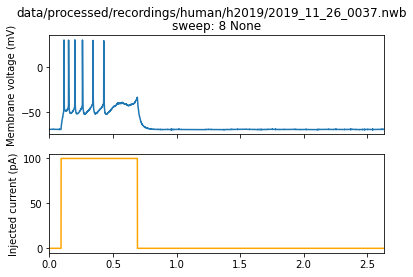

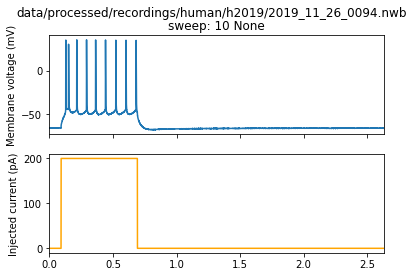

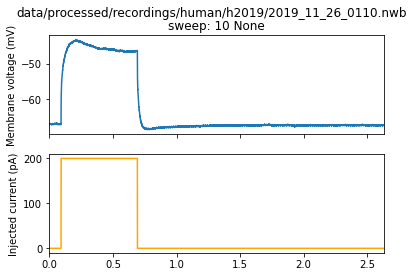

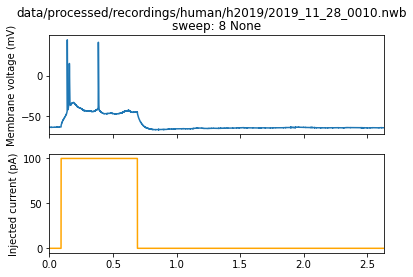

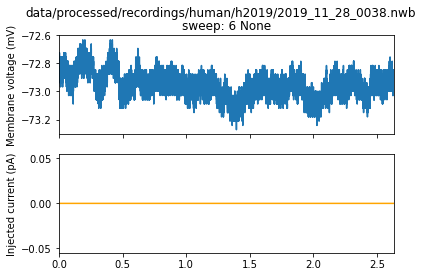

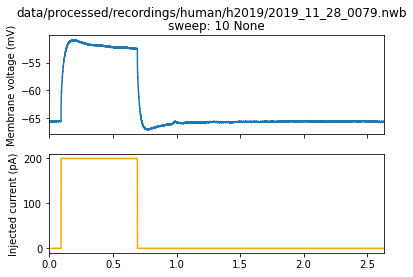

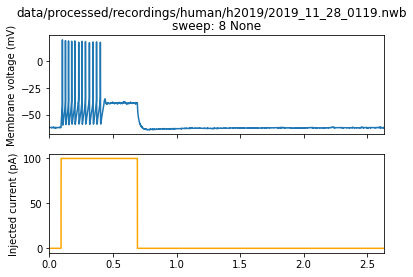

In [9]:
for i, row in h2019[h2019.stimulus_type == 'longsquare'].sort_values('file_name').iterrows():
    try:
        utils.plot_nwb_sweep(file_name=row.path, ontology=ontology_path)
    except TypeError as e:
        print(f'Error{e} with file {row.file_name}')

In [10]:
h2019[h2019.stimulus_type == 'longsquare'].shape

(48, 50)

In [11]:
data_dict = {}
for i, row in h2019[h2019.stimulus_type == 'longsquare'].sort_values('file_name').iterrows():
    print(f'{row.file_name}')
    try:
        data_set = create_ephys_data_set(nwb_file=row.path, ontology=ontology_path)
        cell_features, sweep_features, cell_record, sweep_records, _, _ = extract_data_set_features(data_set)
        long_square_table = data_set.filtered_sweep_table(stimuli=data_set.ontology.long_square_names)
        long_square_sweeps = data_set.sweep_set(long_square_table.sweep_number)
        long_square_sweeps = data_set.sweep_set()

        # Select epoch corresponding to the actual recording from the sweeps
        # and align sweeps so that the experiment would start at the same time
        long_square_sweeps.select_epoch("recording")

        # find the start and end time of the stimulus
        # (treating the first sweep as representative)
        stim_start_index, stim_end_index = get_stim_epoch(long_square_sweeps.i[0], test_pulse=False)
        stim_start_time = long_square_sweeps.t[0][stim_start_index]
        stim_end_time = long_square_sweeps.t[0][stim_end_index]

        stim_start_time = row.stim_start_time
        stim_end_time = row.stim_end_time

        # build the extractors
        spfx = SpikeFeatureExtractor(start=stim_start_time, end=stim_end_time, filter = 1)
        sptfx = SpikeTrainFeatureExtractor(start=stim_start_time, end=stim_end_time, baseline_interval=0.0001)

        # run the analysis and print out a few of the features
        long_square_analysis = spa.LongSquareAnalysis(spfx, sptfx, subthresh_min_amp=-100.0)
        data = long_square_analysis.analyze(long_square_sweeps)    

        specimen_dict = summarize_ls_ephys_features(data)
        data_dict[row.file_name] = specimen_dict
        
    except (AssertionError, AttributeError, TypeError, FeatureError) as e:
        print(f'Error: {e} \n') 

19122003.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

19122026.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

19128006.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


19128040.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

19128061.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


19128068.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


19129014.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

Error: The number of func parameters=3 must not exceed the number of data points=2 

19129022.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


19129024.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


19129037.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


19129040.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

19129043.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


19129047.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


19129058.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

19129072.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

19228030.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

19228044.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


19228058.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

19228068.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


19319025.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


19320001.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


19320007.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


19320017.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


19320022.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


19320025.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


19320030.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


19320041.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

19328001.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

19328009.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

19328019.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

19328034.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

19328039.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

19328046.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

19o10010.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


19o10045.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


19o10054.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximu

19o10065.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2019_11_04_0001.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2019_11_04_0083.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that p

2019_11_26_0006.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximu

2019_11_26_0019.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2019_11_26_0037.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that p

2019_11_26_0094.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2019_11_26_0110.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2019_11_28_0010.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2019_11_28_0038.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximu

2019_11_28_0079.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2019_11_28_0119.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


In [12]:
dt_df = pd.DataFrame(data_dict)
h2019_longsquare_df = dt_df.T

h2019_longsquare_df.to_csv(features_output_path / 'human2019_longsquares.csv')

In [13]:
h2019_longsquare_df.shape

(47, 26)

In [14]:
h2019_LS_error = h2019[(h2019.stimulus_type == 'longsquare') & ~(h2019.file_name.isin(h2019_longsquare_df.index))]

# Process 2018 human longsquares

In [15]:
h2018meta['Stimulus type'].value_counts()

Long_Square    18
Name: Stimulus type, dtype: int64

In [16]:
h2018meta.columns

Index(['Data Type', 'Exp. Date', 'Case #', 'Cell #', 'Cell Layer', 'Stim Type',
       'Threshold', 'Gain Value', 'ZD', 'Hold', 'Unnamed: 12', 'Gain',
       'Offset', 'Response Channel', 'Command Channel', 'RMP', 'Stimulus type',
       'subject_id', 'sex', 'age', 'seizure_duration_years',
       'diagnosis_Epilepsy', 'diagnosis_Tumor', 'resection_location', 'drugs',
       'internal_soln', 'external_soln', 'file_name', 'path', 'experimenter',
       'file_id', 'resp_chan', 'resp_gain', 'rmp_error', 'abf_tag', 'rmp_val',
       'resp_offset', 'abf_version', 'resp_sampling_rate', 'stim_name',
       'file_time', 'stim_chan', 'stim_gain', 'stim_path', 'valid_stim',
       'stim_amp_vec', 'stim_duration', 'stim_start_time', 'stim_end_time',
       'num_sweeps', 'stim_sampling_rate'],
      dtype='object')

In [17]:
h2018meta[h2018meta['Stimulus type'] == 'Long_Square'].head()

,Data Type,Exp. Date,Case #,Cell #,Cell Layer,Stim Type,Threshold,Gain Value,ZD,Hold,...,stim_chan,stim_gain,stim_path,valid_stim,stim_amp_vec,stim_duration,stim_start_time,stim_end_time,num_sweeps,stim_sampling_rate
0,Human,March_20_2018,First,C1,L23,Firing,n.a,n.a,n.a,n.a,...,1,400,data/raw/recordings/Human tissue/Human tissue-...,True,[-551. -450. -353. ... 550. 649. 748.],0.1496,0.0374,1.0362,14,10000
1,Human,March_20_2018,First,C3,L23,Firing,n.a,n.a,n.a,n.a,...,1,400,data/raw/recordings/Human tissue/Human tissue-...,True,[-549. -450. -349. ... 350. 450. 550.],0.2729,0.0373,1.0361,12,10000
2,Human,March_20_2018,Second,C5,L23,Firing,n.a,n.a,n.a,n.a,...,1,400,data/raw/recordings/Human tissue/Human tissue-...,True,[-550. -449. -349. ... 651. 752. 851.],0.4860,0.0372,1.0369,15,10000
3,Human,April_26_2018,n.a,C1,L23,Firing,n.a,n.a,n.a,n.a,...,1,400,data/raw/recordings/Human tissue/Human tissue-...,True,[-600. -500. -400. ... 400. 499. 599.],0.2952,0.0382,1.0370,13,10000
4,Human,April_26_2018,n.a,C2,L23,Firing,n.a,n.a,n.a,n.a,...,1,400,data/raw/recordings/Human tissue/Human tissue-...,True,[-600. -500. -400. ... 700. 801. 901.],0.3348,0.0373,1.0371,16,10000


In [18]:
h2018 = h2018.merge(h2018meta.drop(['file_name', 'path'], axis=1), on='file_id')#.drop(cols_to_drop, axis=1)

In [19]:
h2018[h2018.file_id == '18329062']

,file_name,path,file_id,Data Type,Exp. Date,Case #,Cell #,Cell Layer,Stim Type,Threshold,...,stim_chan,stim_gain,stim_path,valid_stim,stim_amp_vec,stim_duration,stim_start_time,stim_end_time,num_sweeps,stim_sampling_rate
16,18329062.nwb,data/processed/recordings/human/h2018/18329062...,18329062,Human,March_29_2018,n.a,C13,L23,Firing,n.a,...,1,400,data/raw/recordings/Human tissue/Human tissue-...,True,[-598. -499. -399. ... 499. 601. 700.],0.1425,0.0373,1.0368,14,10000


In [20]:
data_dict = {}
for i, row in h2018[h2018['Stimulus type'] == 'Long_Square'].iterrows():
    print(f'{row.file_name}')
    try:
        data_set = create_ephys_data_set(nwb_file=row.path, ontology=ontology_path)
        cell_features, sweep_features, cell_record, sweep_records, _, _ = extract_data_set_features(data_set)
        long_square_table = data_set.filtered_sweep_table(stimuli=data_set.ontology.long_square_names)
        long_square_sweeps = data_set.sweep_set(long_square_table.sweep_number)
        long_square_sweeps = data_set.sweep_set()

        # Select epoch corresponding to the actual recording from the sweeps
        # and align sweeps so that the experiment would start at the same time
        long_square_sweeps.select_epoch("recording")

        # find the start and end time of the stimulus
        # (treating the first sweep as representative)
        stim_start_index, stim_end_index = get_stim_epoch(long_square_sweeps.i[0], test_pulse=False)
        stim_start_time = long_square_sweeps.t[0][stim_start_index]
        stim_end_time = long_square_sweeps.t[0][stim_end_index]

        #stim_start_time = 0.2
        #stim_end_time = 1.8

        stim_start_time = row.stim_start_time
        stim_end_time = row.stim_end_time

        # build the extractors
        spfx = SpikeFeatureExtractor(start=stim_start_time, end=stim_end_time, filter = 1)
        sptfx = SpikeTrainFeatureExtractor(start=stim_start_time, end=stim_end_time, baseline_interval=0.0001)

        # run the analysis and print out a few of the features
        long_square_analysis = spa.LongSquareAnalysis(spfx, sptfx, subthresh_min_amp=-100.0)
        data = long_square_analysis.analyze(long_square_sweeps)    

        specimen_dict = summarize_ls_ephys_features(data)
        #data_dict[curr_file] = specimen_dict
        data_dict[row.file_name] = specimen_dict
        
    except (AssertionError, AttributeError, TypeError, FeatureError) as e:
        print(f'Error: {e} \n')

18329051.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

18329044.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

18o22020.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


18129004.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

18426010.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

18320005.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


18426017.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


18201011.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


18220008.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


18320021.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

18201004.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


18220019.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


18320031.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

18329014.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

18o22001.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


18129009.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

18329062.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


18o22010.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


In [21]:
dt_df = pd.DataFrame(data_dict)
h2018_longsquare_df = dt_df.T

In [22]:
h2018[h2018['Stimulus type'] == 'Long_Square'].shape

(18, 51)

In [23]:
h2018_longsquare_df.to_csv(features_output_path / 'human2018_longsquares.csv')

In [24]:
h2018_LS_error = h2018[(h2018['Stimulus type'] == 'Long_Square') & ~(h2018.file_name.isin(h2018_longsquare_df.index))]

In [25]:
h2018_LS_error

,file_name,path,file_id,Data Type,Exp. Date,Case #,Cell #,Cell Layer,Stim Type,Threshold,...,stim_chan,stim_gain,stim_path,valid_stim,stim_amp_vec,stim_duration,stim_start_time,stim_end_time,num_sweeps,stim_sampling_rate


## Process 2019 mouse longsquares

In [26]:
m2019meta.stimulus_type.value_counts()

longsquare    7
Name: stimulus_type, dtype: int64

In [27]:
m2019meta.head()

,Data Type,Exp. Date,Cell #,Cell Layer,Stim Type,ZD status,stimulus_type,Gain,Offset,Response Channel,...,stim_chan,stim_gain,stim_path,valid_stim,stim_amp_vec,stim_duration,stim_start_time,stim_end_time,num_sweeps,stim_sampling_rate
0,Mouse,Oct 22_2019,C2,L5,Firing,Before ZD,longsquare,1.0,0.0,Vm_Sec (mV),...,1,1,data/raw/recordings/Mouse data/Mouse data_2019...,True,[-300. -250. -200. ... 300. 350. 400.],0.6,0.0921,0.69205,15,20000
1,Mouse,Oct 22_2019,C3,L5,Firing,Before ZD,longsquare,1.0,0.0,Vm_Sec (mV),...,1,1,data/raw/recordings/Mouse data/Mouse data_2019...,True,[-300. -250. -200. ... 250. 300. 350.],0.6,0.0921,0.69205,14,20000
2,Mouse,Oct 23_2019,C1,L5,Firing,n.a,longsquare,1.0,0.0,Vm_Sec (mV),...,1,1,data/raw/recordings/Mouse data/Mouse data_2019...,True,[-300. -250. -200. ... 250. 300. 350.],0.6,0.0921,0.69205,14,20000
3,Mouse,Oct 23_2019,C2,L5,Firing,n.a,longsquare,1.0,0.0,Vm_Sec (mV),...,1,1,data/raw/recordings/Mouse data/Mouse data_2019...,True,[-300. -250. -200. ... 300. 350. 400.],0.6,0.0921,0.69205,15,20000
4,Mouse,Oct 23_2019,C3,L5,Firing,n.a,longsquare,1.0,0.0,Vm_Sec (mV),...,1,1,data/raw/recordings/Mouse data/Mouse data_2019...,True,[-300. -250. -200. ... 250. 300. 350.],0.6,0.0921,0.69205,14,20000


In [28]:
m2019 = m2019.merge(m2019meta.drop(['file_name', 'path'], axis=1), on='file_id')#.drop(cols_to_drop, axis=1)

In [29]:
m2019[m2019.stimulus_type == 'longsquare'].shape

(7, 37)

In [30]:
data_dict = {}
for i, row in m2019[m2019.stimulus_type == 'longsquare'].iterrows():
    print(f'{row.file_name}')
    try:
        data_set = create_ephys_data_set(nwb_file=row.path, ontology=ontology_path)
        cell_features, sweep_features, cell_record, sweep_records, _, _ = extract_data_set_features(data_set)
        long_square_table = data_set.filtered_sweep_table(stimuli=data_set.ontology.long_square_names)
        long_square_sweeps = data_set.sweep_set(long_square_table.sweep_number)
        long_square_sweeps = data_set.sweep_set()

        # Select epoch corresponding to the actual recording from the sweeps
        # and align sweeps so that the experiment would start at the same time
        long_square_sweeps.select_epoch("recording")

        # find the start and end time of the stimulus
        # (treating the first sweep as representative)
        stim_start_index, stim_end_index = get_stim_epoch(long_square_sweeps.i[0], test_pulse=False)
        stim_start_time = long_square_sweeps.t[0][stim_start_index]
        stim_end_time = long_square_sweeps.t[0][stim_end_index]

        #stim_start_time = 0.2
        #stim_end_time = 1.8

        stim_start_time = row.stim_start_time
        stim_end_time = row.stim_end_time

        
        # build the extractors
        spfx = SpikeFeatureExtractor(start=stim_start_time, end=stim_end_time, filter = 1)
        sptfx = SpikeTrainFeatureExtractor(start=stim_start_time, end=stim_end_time, baseline_interval=0.0001)

        # run the analysis and print out a few of the features
        long_square_analysis = spa.LongSquareAnalysis(spfx, sptfx, subthresh_min_amp=-100.0)
        data = long_square_analysis.analyze(long_square_sweeps)    

        specimen_dict = summarize_ls_ephys_features(data)
        data_dict[row.file_name] = specimen_dict
        
    except (AssertionError, AttributeError, TypeError, FeatureError) as e:
        print(f'Error: {e} \n') 

19o23003.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


19o23001.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


19o23010.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


19o23039.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


19o22018.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that p

19o22001.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


19o23046.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


In [31]:
dt_df = pd.DataFrame(data_dict)
m2019_longsquare_df = dt_df.T

In [32]:
m2019_longsquare_df

,adapt,avg_rate,first_isi,isi_cv,latency,mean_isi,median_isi,stim_amp,threshold_v,peak_v,...,fast_trough_t,trough_t,rheo_first_isi,v_baseline,rheobase_i,fi_fit_slope,sag,vm_for_sag,input_resistance,tau
19o23003.nwb,-0.005551,16.668056,0.05940,0.039541,0.03285,0.058878,0.05990,100.0,-46.539307,15.289307,...,0.25365,0.27115,0.20835,-65.897621,50.0,0.129773,0.080303,-95.794678,151.367187,0.014257
19o23001.nwb,0.015317,18.334861,0.04265,0.089746,0.03295,0.053325,0.05520,100.0,-44.036865,28.839111,...,0.39140,0.41365,0.27560,-61.993191,50.0,0.159537,0.061384,-89.569084,117.797852,0.013181
19o23010.nwb,0.023962,16.668056,0.04875,0.097611,0.02325,0.062678,0.06335,250.0,-37.170410,17.089844,...,0.17510,0.18790,0.11745,-73.428566,200.0,0.163347,0.099885,-95.825195,92.163086,0.005935
19o23039.nwb,0.029927,16.668056,0.04125,0.128442,0.04085,0.060044,0.06255,150.0,-48.217773,32.928467,...,0.20815,0.23955,0.11640,-72.532143,100.0,0.088103,0.108956,-101.867676,121.154785,0.017404
19o22018.nwb,0.021133,28.335695,0.02095,0.139971,0.02690,0.035416,0.03635,150.0,-36.224365,32.867432,...,0.22145,0.24770,0.14515,-73.844910,100.0,0.193349,0.156991,-102.050774,169.982910,0.008777
19o22001.nwb,0.012891,20.001667,0.04230,0.078772,0.02685,0.049823,0.05085,150.0,-43.823242,30.975340,...,0.23280,0.24800,0.18540,-63.204956,100.0,0.194064,0.051621,-85.479736,91.247559,0.008264
19o23046.nwb,0.056699,13.334445,0.04505,0.185591,0.04610,0.078821,0.08570,200.0,-42.785645,23.315430,...,0.31830,0.36855,NaN,-71.346031,150.0,0.135249,0.095768,-93.414307,89.416504,0.010064


In [33]:
m2019_longsquare_df.to_csv(features_output_path / 'mouse2019_longsquares.csv')

## Process 2018 mouse longsquares

In [34]:
m2018meta.stimulus_type.value_counts()

longsquare    5
ramp          4
Name: stimulus_type, dtype: int64

In [35]:
m2018 = m2018.merge(m2018meta.drop(['file_name', 'path'], axis=1), on='file_id')#.drop(cols_to_drop, axis=1)

In [36]:
data_dict = {}
for i, row in m2018[m2018.stimulus_type == 'longsquare'].iterrows():
    print(f'{row.file_name}')
    try:
        data_set = create_ephys_data_set(nwb_file=row.path, ontology=ontology_path)
        cell_features, sweep_features, cell_record, sweep_records, _, _ = extract_data_set_features(data_set)
        long_square_table = data_set.filtered_sweep_table(stimuli=data_set.ontology.long_square_names)
        long_square_sweeps = data_set.sweep_set(long_square_table.sweep_number)
        long_square_sweeps = data_set.sweep_set()

        # Select epoch corresponding to the actual recording from the sweeps
        # and align sweeps so that the experiment would start at the same time
        long_square_sweeps.select_epoch("recording")

        # find the start and end time of the stimulus
        # (treating the first sweep as representative)
        stim_start_index, stim_end_index = get_stim_epoch(long_square_sweeps.i[0], test_pulse=False)
        stim_start_time = long_square_sweeps.t[0][stim_start_index]
        stim_end_time = long_square_sweeps.t[0][stim_end_index]

        stim_start_time = row.stim_start_time #0.2
        stim_end_time = row.stim_end_time#1.8

        # build the extractors
        spfx = SpikeFeatureExtractor(start=stim_start_time, end=stim_end_time, filter = 1)
        sptfx = SpikeTrainFeatureExtractor(start=stim_start_time, end=stim_end_time, baseline_interval=0.0001)

        # run the analysis and print out a few of the features
        long_square_analysis = spa.LongSquareAnalysis(spfx, sptfx, subthresh_min_amp=-100.0)
        data = long_square_analysis.analyze(long_square_sweeps)    

        specimen_dict = summarize_ls_ephys_features(data)
        data_dict[row.file_name] = specimen_dict
        
    except (AssertionError, AttributeError, TypeError, FeatureError) as e:
        print(f'Error: {e} \n') 

18118024.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

18208014.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

18208024.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

2018_02_08_0001.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephys

18130014.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephys

In [37]:
dt_df = pd.DataFrame(data_dict)
m2018_longsquare_df = dt_df.T

In [38]:
m2018_longsquare_df

,adapt,avg_rate,first_isi,isi_cv,latency,mean_isi,median_isi,stim_amp,threshold_v,peak_v,...,fast_trough_t,trough_t,rheo_first_isi,v_baseline,rheobase_i,fi_fit_slope,sag,vm_for_sag,input_resistance,tau
18118024.nwb,0.009277,21.001050,0.01855,0.108196,0.0078,0.024880,0.024675,150.390625,-33.550194,113.086777,...,0.06285,0.0628,NaN,-71.917465,100.219727,0.096210,0.034566,-98.461082,484.756261,0.021556
18208014.nwb,0.079737,15.010507,0.00870,0.447010,0.0303,0.064493,0.076000,60.302734,3.648876,211.931366,...,0.18350,0.1833,0.0103,-53.336838,20.629883,0.051392,0.149516,-86.377975,987.490535,NaN
18208024.nwb,0.187108,4.007614,0.07430,0.292805,0.0405,0.118033,0.121000,100.830078,2.448048,162.970520,...,0.13240,0.1764,0.1608,-54.568958,60.180664,-0.005014,0.268748,-115.960167,817.901134,NaN
2018_02_08_0001.nwb,0.036768,10.004002,0.05300,0.175405,0.0206,0.099189,0.103300,99.853516,-34.997070,145.667007,...,0.09450,0.1694,0.2120,-85.220291,59.814453,0.081522,0.319892,-104.577156,716.463208,NaN
18130014.nwb,0.073511,8.012018,0.08090,0.309600,0.0456,0.134157,0.132000,90.332031,-34.238476,133.608200,...,0.15180,0.8907,NaN,-103.929543,49.926758,0.111135,0.193555,-113.584190,944.317520,NaN


In [39]:
m2018_longsquare_df.to_csv(features_output_path / 'mouse2018_longsquares.csv')

## Natcom data

In [40]:
nat_com_nwb_file_df = utils.summary_df(Path('./data/processed/recordings/human/natcom/'), suffix='.nwb')
nat_com_nwb_file_df['file_id'] = nat_com_nwb_file_df.file_name.apply(lambda x: x.rstrip('.nwb'))

In [41]:
nat_com_nwb_file_df

,file_name,path,file_id
0,15o08032.nwb,data/processed/recordings/human/natcom/15o0803...,15o08032
1,2016_03_03_0103.nwb,data/processed/recordings/human/natcom/2016_03...,2016_03_03_0103
2,2016_02_29_0065.nwb,data/processed/recordings/human/natcom/2016_02...,2016_02_29_0065
3,19320017.nwb,data/processed/recordings/human/natcom/1932001...,19320017
4,19320001.nwb,data/processed/recordings/human/natcom/1932000...,19320001
...,...,...,...
104,19320024.nwb,data/processed/recordings/human/natcom/1932002...,19320024
105,19129047.nwb,data/processed/recordings/human/natcom/1912904...,19129047
106,2016_03_01_0000.nwb,data/processed/recordings/human/natcom/2016_03...,2016_03_01_0000
107,15o08002.nwb,data/processed/recordings/human/natcom/15o0800...,15o08002


In [42]:
# Read in metadata from Shreejoy's github repo

# read final csv that has the ouput of metadata gathering process
nat_com_meta_url = 'https://raw.githubusercontent.com/stripathy/valiante_lab_abf_process/master/output_files/cell_final_raw_meta_df.csv'
nat_com_meta = pd.read_csv(nat_com_meta_url)
nat_com_meta['file_id'] = nat_com_meta.cell_id.apply(lambda x: x.rstrip('.abf'))

In [43]:
nat_com_meta[nat_com_meta.cell_id.str.contains('19122024')].iloc[0]

Unnamed: 0                                                          157
cell_id                                                    19122024.abf
expt_date                                                    2019-01-22
layer_name                                                          L3c
cell_type                                                           Pyr
recorder_name                                                   Homeira
full_path             /Users/stripathy/Downloads/homeira_new_intrins...
abf_tag                                                  C6-L3 -63.7 mv
abf_version                                                     1.8.3.0
file_time                                       2019-01-22 18:07:33.468
num_sweeps                                                           28
resp_chan                                                             2
resp_gain                                                          0.25
resp_offset                                                     

In [44]:
nat_com_nwb_file_df = nat_com_nwb_file_df.merge(nat_com_meta, left_on='file_id', right_on='file_id')

In [45]:
data_dict = {}
for i, row in nat_com_nwb_file_df.iterrows():
    print(f'{row.file_name}')
    try:
        data_set = create_ephys_data_set(nwb_file=row.path, ontology=ontology_path)
        cell_features, sweep_features, cell_record, sweep_records, _, _ = extract_data_set_features(data_set)
        long_square_table = data_set.filtered_sweep_table(stimuli=data_set.ontology.long_square_names)
        long_square_sweeps = data_set.sweep_set(long_square_table.sweep_number)
        long_square_sweeps = data_set.sweep_set()

        # Select epoch corresponding to the actual recording from the sweeps
        # and align sweeps so that the experiment would start at the same time
        long_square_sweeps.select_epoch("recording")

        # find the start and end time of the stimulus
        # (treating the first sweep as representative)
        stim_start_index, stim_end_index = get_stim_epoch(long_square_sweeps.i[0], test_pulse=False)
        stim_start_time = long_square_sweeps.t[0][stim_start_index]
        stim_end_time = long_square_sweeps.t[0][stim_end_index]

        stim_start_time = row.stim_start_time
        stim_end_time = row.stim_end_time

        # build the extractors
        spfx = SpikeFeatureExtractor(start=stim_start_time, end=stim_end_time, filter = 1)
        sptfx = SpikeTrainFeatureExtractor(start=stim_start_time, end=stim_end_time, baseline_interval = .05)

        # run the analysis and print out a few of the features
        long_square_analysis = spa.LongSquareAnalysis(spfx, sptfx, subthresh_min_amp=-500.0)
        data = long_square_analysis.analyze(long_square_sweeps)    

        specimen_dict = summarize_ls_ephys_features(data)
        #data_dict[curr_file] = specimen_dict
        data_dict[row.file_name] = specimen_dict
        
    except (AssertionError, AttributeError, TypeError, FeatureError) as e:
    #except FeatureError as e:
        print(f'Error: {e} \n') # {row.filename} \n')

15o08032.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

2016_03_03_0103.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

2016_02_29_0065.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

19320017.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


19320001.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


19128036.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

2016_03_03_0100.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

20140127_600_1_0118.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephys

Error: No spiking long square sweeps, cannot compute cell features. 

2020_03_02_0023.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2016_02_04_0042.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

13d03005.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephys

Error: No spiking long square sweeps, cannot compute cell features. 

2016_02_25_0005.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

2016_01_28_0004.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

20131211_600_1_0067.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephys

Error: No spiking long square sweeps, cannot compute cell features. 

15o08020.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


20131211_600_1_0066.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephys

Error: No spiking long square sweeps, cannot compute cell features. 

19129072.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

19320007.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2016_02_04_0045.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


15o08022.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2016_01_28_0012.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

2016_02_25_0007.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


13d03007.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephys

Error: No spiking long square sweeps, cannot compute cell features. 

2016_03_01_0047.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2020_01_06_0082.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


20131211_600_1_0002.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephys

Error: No spiking long square sweeps, cannot compute cell features. 

2020_01_27_0002.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2015_11_09_0053.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

19129015.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

2020_01_28_0008.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2020_01_06_0095.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2015_11_09_0078.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2016_02_04_0009.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

2016_02_04_0021.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


13d02022.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephys

Error: No spiking long square sweeps, cannot compute cell features. 

19128068.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2016_03_03_0002.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


20131211_600_1_0160.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephys

Error: No spiking long square sweeps, cannot compute cell features. 

19129004.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2020_01_06_0090.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


19128044.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


Error: Cannot fit f-I curve slope with less than two sweeps 

2020_01_27_0038.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2019_11_26_0094.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


19122024.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

2016_02_04_0018.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


13n05011.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephys

Error: No spiking long square sweeps, cannot compute cell features. 

2016_02_25_0073.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

2019_09_03_0088.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  


Error: <class 'tuple'> is not a stimulus or response PatchClampSeries 

19122026.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

2016_02_04_0033.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

13n21007.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephys

Error: No spiking long square sweeps, cannot compute cell features. 

19129037.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2019_11_26_0110.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2016_02_25_0082.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2020_01_06_0048.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2015_11_09_0106.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2019_11_28_0079.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2019_11_28_0119.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


20140127_600_1_0158.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephys

Error: No spiking long square sweeps, cannot compute cell features. 

19122017.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


19122003.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

2016_02_29_0032.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

2016_02_25_0134.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

2015_11_09_0107.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

2019_11_28_0093.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


19320041.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

2020_01_28_0017.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that p

19129022.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


13d03040.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephys

Error: No spiking long square sweeps, cannot compute cell features. 

2020_01_28_0029.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2020_01_06_0063.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2016_02_04_0015.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2016_02_04_0029.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

2020_01_27_0008.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximu

19128061.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2016_02_25_0255.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

2019_09_03_0045.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  


Error: <class 'tuple'> is not a stimulus or response PatchClampSeries 

19129024.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


13d02004.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephys

Error: No spiking long square sweeps, cannot compute cell features. 

20131211_600_1_0184.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephys

Error: No spiking long square sweeps, cannot compute cell features. 

20131211_600_1_0190.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephys

Error: No spiking long square sweeps, cannot compute cell features. 

19129040.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

20131211_600_1_0108.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephys

Error: No spiking long square sweeps, cannot compute cell features. 

2020_01_06_0017.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


15o08007.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

19129069.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

19129057.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

15o08038.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

13d02049.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephys

Error: No spiking long square sweeps, cannot compute cell features. 

19128003.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


20131211_600_1_0081.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephys

Error: No spiking long square sweeps, cannot compute cell features. 

2020_01_27_0042.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)


20131211_600_1_0042.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephys

Error: No spiking long square sweeps, cannot compute cell features. 

15o08011.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2016_03_03_0054.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

13d03008.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephys

Error: No spiking long square sweeps, cannot compute cell features. 

19129052.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


19320025.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2019_09_03_0036.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  


Error: <class 'tuple'> is not a stimulus or response PatchClampSeries 

2016_01_28_0019.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2015_11_09_0017.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2015_11_09_0003.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


19320030.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2019_09_03_0023.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  


Error: <class 'tuple'> is not a stimulus or response PatchClampSeries 

19320024.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


19129047.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2016_03_01_0000.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


15o08002.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


15o08017.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


In [46]:
dt_df = pd.DataFrame(data_dict)
nat_com_longsquare_df = dt_df.T

In [47]:
nat_com_longsquare_df

,adapt,avg_rate,first_isi,isi_cv,latency,mean_isi,median_isi,stim_amp,threshold_v,peak_v,...,fast_trough_t,trough_t,rheo_first_isi,v_baseline,rheobase_i,fi_fit_slope,sag,vm_for_sag,input_resistance,tau
15o08032.nwb,0.025671,12.254771,0.045904,0.185785,0.024992,0.078591,0.085178,150.000000,-46.544189,51.179199,...,0.476385,0.517801,0.063552,-59.161621,100.000000,0.024064,0.080064,-80.827637,51.609583,0.012116
2016_03_03_0103.nwb,0.158713,11.111593,0.013561,0.468069,0.073623,0.084861,0.103924,249.999985,-37.310596,50.152786,...,0.392656,0.393016,0.015541,-65.452423,200.000000,0.037880,0.097288,-84.393112,43.874104,0.017017
2016_02_29_0065.nwb,-0.002228,29.167931,0.040622,0.090739,0.023041,0.032983,0.033031,100.000000,-39.903942,38.625420,...,0.300432,0.301692,0.072363,-63.777344,50.000000,0.175765,0.167399,-98.093346,213.170767,0.028196
19320017.nwb,0.232653,6.667778,0.061800,0.372042,0.063800,0.107767,0.102000,150.024414,-33.044117,41.464554,...,0.566500,0.647600,NaN,-73.134575,99.487305,0.059596,0.025747,-98.031296,94.525866,0.012607
19320001.nwb,0.307538,8.337502,0.018900,0.531679,0.052800,0.100975,0.115450,148.803711,-39.222244,53.749565,...,0.298800,0.299000,0.030500,-64.493660,99.975586,0.066464,0.109240,-101.981644,84.223703,0.015239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19320024.nwb,NaN,3.333889,0.077100,0.000000,0.051200,0.077100,0.077100,199.951172,-39.413799,49.880638,...,0.488800,0.540600,NaN,-76.193100,149.902344,0.028565,0.066192,-98.602646,75.450905,0.010458
19129047.nwb,0.086530,13.373454,0.030200,0.294825,0.028100,0.067171,0.072000,249.755859,-41.258205,54.719585,...,0.237400,0.237800,0.052100,-66.979088,199.707031,0.060016,0.089398,-94.480865,65.147266,0.009334
2016_03_01_0000.nwb,0.145762,8.333694,0.043022,0.374860,0.036241,0.101152,0.110884,350.000000,-44.517334,58.473389,...,0.310692,0.343574,0.072723,-61.950840,300.000000,0.038386,0.111151,-71.842773,24.020238,0.008042
15o08002.nwb,0.082053,6.535878,0.058145,0.299605,0.048149,0.161088,0.164847,150.000000,-45.566212,46.224560,...,0.520657,0.682750,0.760583,-63.438057,100.000000,0.046939,0.294718,-88.992722,60.462601,0.018802


In [48]:
nat_com_longsquare_df.to_csv(features_output_path / 'natcom_longsquares.csv')